In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import *

import torch  # 导入torch
import torch.nn as nn  # 导入torch.nn
import torch.nn.functional as F  # 导入torch.nn.functional
import gym  # 导入gym
from tqdm.tk import tqdm

from nagel.environment import Env

In [17]:
travel_time = [1, 1, 1, 1]

BATCH_SIZE = 32  # 样本数量
LR = 0.01  # 学习率
EPSILON = 0.1  # greedy policy
GAMMA = 0.9  # reward discount
TARGET_REPLACE_ITER = 10  # 目标网络更新频率
MEMORY_CAPACITY = 2000  # 记忆库容量

env = Env()
env_eva= Env()
N_ACTIONS = 2
N_STATES = 3  # 状态个数 (3个,activity,dur,start_time)

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.observation_space = N_STATES
        self.action_space = N_ACTIONS

        self.layer = nn.Sequential(
            nn.Linear(3,15),
            nn.ReLU(),
            nn.Linear(15, self.action_space)
        )

    def forward(self, x):  # 定义forward函数 (x为状态)
        return self.layer(x)


In [19]:
net = Net()
net.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[-0.1488, -0.4656,  0.1212],
                      [-0.3502, -0.0876, -0.1386],
                      [-0.5770,  0.2128,  0.4380],
                      [-0.3853,  0.4406, -0.5671],
                      [ 0.0921,  0.1067,  0.3318],
                      [ 0.1746, -0.5167, -0.5300],
                      [ 0.4595,  0.2939, -0.1970],
                      [-0.4150, -0.4962,  0.1397],
                      [-0.2593,  0.4636, -0.4756],
                      [-0.0023, -0.1499,  0.3858],
                      [-0.0007, -0.3756, -0.0511],
                      [ 0.2311, -0.2734,  0.3241],
                      [ 0.4907,  0.1008,  0.0055],
                      [-0.3873,  0.0412,  0.2243],
                      [ 0.4182,  0.3406,  0.1358]])),
             ('layer.0.bias',
              tensor([-0.1105,  0.3451, -0.1680, -0.1041, -0.3307,  0.3599,  0.4843,  0.0203,
                      -0.4090,  0.5637,  0.0671, -0.2405,  0.4619,  0.3721, 

In [20]:
dummy = torch.rand([3])
dummy

tensor([0.3658, 0.7959, 0.4248])

In [21]:
net(dummy)

tensor([-0.0447,  0.5146], grad_fn=<AddBackward0>)

/tmp/ipykernel_27384/3121308165.py:73: TqdmExperimentalWarning: GUI is experimental/alpha
  for i in tqdm(range(2000)):  # 400个episode循环


<<<<<<<<<Episode: 0
episode0---reward_sum: 139.0
<<<<<<<<<Episode: 1
episode1---reward_sum: 158.0
<<<<<<<<<Episode: 2
episode2---reward_sum: 149.0
<<<<<<<<<Episode: 3
episode3---reward_sum: 149.0
<<<<<<<<<Episode: 4
episode4---reward_sum: 70.0
<<<<<<<<<Episode: 5
episode5---reward_sum: 125.0
<<<<<<<<<Episode: 6
episode6---reward_sum: 911.0
<<<<<<<<<Episode: 7
episode7---reward_sum: 160.0
<<<<<<<<<Episode: 8
episode8---reward_sum: 148.0
<<<<<<<<<Episode: 9
episode9---reward_sum: 148.0
<<<<<<<<<Episode: 10
episode10---reward_sum: 56.0
<<<<<<<<<Episode: 11
episode11---reward_sum: 148.0
<<<<<<<<<Episode: 12
episode12---reward_sum: 147.0
<<<<<<<<<Episode: 13
episode13---reward_sum: 931.0
<<<<<<<<<Episode: 14
episode14---reward_sum: 146.0
<<<<<<<<<Episode: 15
episode15---reward_sum: 148.0
<<<<<<<<<Episode: 16
episode16---reward_sum: 894.0
<<<<<<<<<Episode: 17
episode17---reward_sum: 148.0
<<<<<<<<<Episode: 18
episode18---reward_sum: 147.0
<<<<<<<<<Episode: 19
episode19---reward_sum: 63.0
<<<

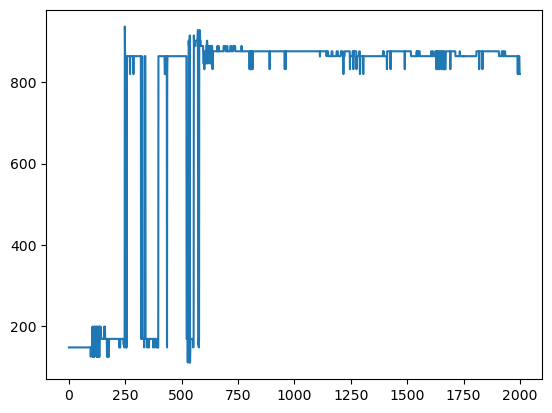

In [22]:
class DQN(object):
    def __init__(self):  # 定义DQN的一系列属性
        self.eval_net, self.target_net = Net(), Net()  # 利用Net创建两个神经网络: 评估网络和目标网络
        self.learn_step_counter = 0  # for target updating
        self.memory_counter = 0  # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))  # 初始化记忆库，一行代表一个transition
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)  # 使用Adam优化器 (输入为评估网络的参数和学习率)
        self.loss_func = nn.MSELoss()  # 使用均方损失函数 (loss(xi, yi)=(xi-yi)^2)

    def choose_action(self, x, epsilon):  # 定义动作选择函数 (x为状态)
        x = torch.unsqueeze(torch.FloatTensor(x), 0)  # 将x转换成32-bit floating point形式，并在dim=0增加维数为1的维度
        if np.random.uniform() > epsilon:  # 生成一个在[0, 1)内的随机数，如果小于EPSILON，选择最优动作
            actions_value = self.eval_net.forward(x)  # 通过对评估网络输入状态x，前向传播获得动作值
            action = torch.max(actions_value, 1)[1].data.numpy()  # 输出每一行最大值的索引，并转化为numpy ndarray形式
            action = action[0]  # 输出action的第一个数
        else:  # 随机选择动作
            action = np.random.randint(0, N_ACTIONS)  # 这里action随机等于0或1 (N_ACTIONS = 2)
        return action  # 返回选择的动作 (0或1)

    def store_transition(self, s, a, r, s_):  # 定义记忆存储函数 (这里输入为一个transition)
        transition = np.hstack((s, [a, r], s_))  # 在水平方向上拼接数组
        # 如果记忆库满了，便覆盖旧的数据
        index = self.memory_counter % MEMORY_CAPACITY  # 获取transition要置入的行数
        self.memory[index, :] = transition  # 置入transition
        self.memory_counter += 1  # memory_counter自加1

    def learn(self):  # 定义学习函数(记忆库已满后便开始学习)
        # 目标网络参数更新
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:  # 一开始触发，然后每100步触发
            self.target_net.load_state_dict(self.eval_net.state_dict())  # 将评估网络的参数赋给目标网络
        self.learn_step_counter += 1  # 学习步数自加1

        # 抽取记忆库中的批数据
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)  # 在[0, 2000)内随机抽取32个数，可能会重复
        b_memory = self.memory[sample_index, :]  # 抽取32个索引对应的32个transition，存入b_memory
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        # 将32个s抽出，转为32-bit floating point形式，并存储到b_s中，b_s为32行4列
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES + 1].astype(int))
        # 将32个a抽出，转为64-bit integer (signed)形式，并存储到b_a中 (之所以为LongTensor类型，是为了方便后面torch.gather的使用)，b_a为32行1列
        b_r = torch.FloatTensor(b_memory[:, N_STATES + 1:N_STATES + 2])
        # 将32个r抽出，转为32-bit floating point形式，并存储到b_s中，b_r为32行1列
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        # 将32个s_抽出，转为32-bit floating point形式，并存储到b_s中，b_s_为32行4列

        # 获取32个transition的评估值和目标值，并利用损失函数和优化器进行评估网络参数更新
        q_eval = self.eval_net(b_s).gather(1, b_a)
        # eval_net(b_s)通过评估网络输出32行每个b_s对应的一系列动作值，然后.gather(1, b_a)代表对每行对应索引b_a的Q值提取进行聚合
        q_next = self.target_net(b_s_).detach()
        # q_next不进行反向传递误差，所以detach；q_next表示通过目标网络输出32行每个b_s_对应的一系列动作值
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        # q_next.max(1)[0]表示只返回每一行的最大值，不返回索引(长度为32的一维张量)；.view()表示把前面所得到的一维张量变成(BATCH_SIZE, 1)的形状；最终通过公式得到目标值
        loss = self.loss_func(q_eval, q_target)
        # 输入32个评估值和32个目标值，使用均方损失函数
        self.optimizer.zero_grad()  # 清空上一步的残余更新参数值
        loss.backward()  # 误差反向传播, 计算参数更新值
        self.optimizer.step()  # 更新评估网络的所有参数

    def evaluate(self):
        rw_e_sum = 0
        se = (0,0,0)
        while True:
            a_e = self.choose_action(se,-1)  # 输入该步对应的状态s，选择动作
            done_e, r_e, se_ = env.step(se, a_e)  # 执行动作，获得反馈

            rw_e_sum += r_e  # 逐步加上一个episode内每个step的reward
            if done_e:
                break
            se = se_  # 更新状态
        return rw_e_sum

dqn = DQN()  # 令dqn=DQN类
rw_record = []
for i in tqdm(range(2000)):  # 400个episode循环
    print('<<<<<<<<<Episode: %s' % i)
    s = env.reset()  # 重置环境
    episode_reward_sum = 0  # 初始化该循环对应的episode的总奖励

    while True:  # 开始一个episode (每一个循环代表一步)
        a = dqn.choose_action(s,EPSILON)  # 输入该步对应的状态s，选择动作
        # print("action = ",a)
        done, r, s_ = env.step(s, a)  # 执行动作，获得反馈

        # 修改奖励 (不修改也可以，修改奖励只是为了更快地得到训练好的摆杆)
        if s_ is None:
            s_ = (-1,-1,-1)
            activity_no, start_time, dur = s_
        else:
            activity_no, start_time, dur = s_
        # r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        # r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        # new_r = r1 + r2
        new_r = r
        # print(s, a, new_r, s_)

        dqn.store_transition(s, a, new_r, s_)  # 存储样本
        episode_reward_sum += new_r  # 逐步加上一个episode内每个step的reward

        s = s_  # 更新状态

        if dqn.memory_counter > MEMORY_CAPACITY:  # 如果累计的transition数量超过了记忆库的固定容量2000
            # 开始学习 (抽取记忆，即32个transition，并对评估网络参数进行更新，并在开始学习后每隔100次将评估网络的参数赋给目标网络)
            dqn.learn()


        if done:  # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            rw_record.append(dqn.evaluate())
            break  # 该episode结束
plt.plot(rw_record)


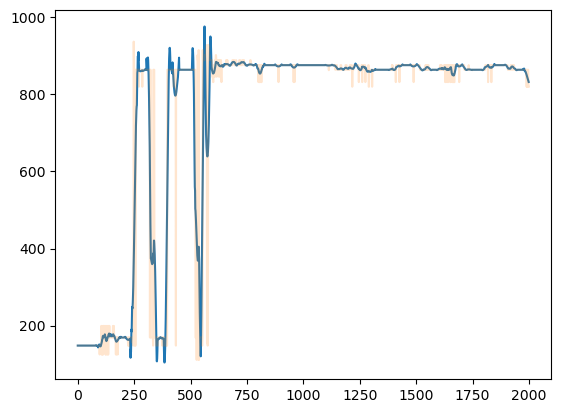

In [23]:
plt.plot(scipy.signal.savgol_filter(rw_record, 30, 3), label="smooth")
plt.plot(rw_record, label="non_smooth", alpha=0.2)

In [ ]:
dqn.target_net.eval()
dqn.target_net.forward(torch.unsqueeze(torch.FloatTensor(torch.tensor((1.0,1.0,11.0))), 0) )

In [ ]:
torch.unsqueeze(torch.FloatTensor(torch.tensor((1.0,1.0,1.0))), 0)

0


/tmp/ipykernel_27384/1703958335.py:11: TqdmExperimentalWarning: GUI is experimental/alpha
  for ep in tqdm(range(episodes)):


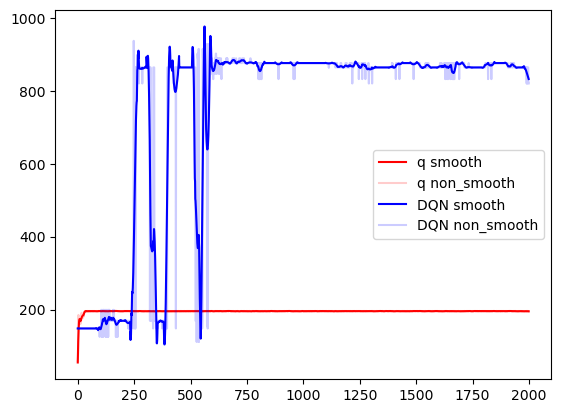

array([[[[ 1.76368502e+02,  8.03917162e+01],
         [ 1.69059093e+02,  9.06451294e+01],
         [ 1.60665750e+02,  9.20824394e+01],
         ...,
         [ 3.50980840e+00,  6.39403889e+01],
         [ 3.04860840e+00,  1.00000000e-01],
         [ 5.48076760e+00,  1.00000000e-01]],

        [[ 1.00000000e-01,  1.00000000e-01],
         [ 1.00000000e-01,  1.00000000e-01],
         [ 1.00000000e-01,  1.00000000e-01],
         ...,
         [ 1.00000000e-01,  1.00000000e-01],
         [ 1.00000000e-01,  1.00000000e-01],
         [ 1.00000000e-01,  1.00000000e-01]],

        [[ 1.00000000e-01,  1.00000000e-01],
         [ 1.00000000e-01,  1.00000000e-01],
         [ 1.00000000e-01,  1.00000000e-01],
         ...,
         [ 1.00000000e-01,  1.00000000e-01],
         [ 1.00000000e-01,  1.00000000e-01],
         [ 1.00000000e-01,  1.00000000e-01]],

        ...,

        [[ 1.13602526e+01, -1.00200000e-01],
         [ 7.21177292e+00, -1.00200000e-01],
         [ 1.00000000e-01,  1.00000000

In [27]:
def train_classical_q(env, epo):
    episodes = epo
    runs = 1
    smooth_rewards = np.zeros(episodes)
    rewards_q = np.zeros(episodes)
    test_score = []
    for r in range(runs):
        print(r)
        q_table_q = np.ones((4, 24, 12, 2)) * 0.1
        with open('data.txt', 'w') as f:
            for ep in tqdm(range(episodes)):
                # old_q_table = q_table_q.copy()
                f.writelines("------------------------------------" + str(ep) + '\n')
                rewards_q[ep] += q_learning(f, env, q_table_q, 0.2, 0.1)
                # diff = np.sum(np.abs(old_q_table - q_table_q))
                # print("diff = ",diff)
                if ep == episodes - 1:
                    test_score.append(test(q_table_q, env, True, f))
                else:
                    test_score.append(test(q_table_q, env, True, f))
                smooth_rewards[ep] += test_score[-1]
        f.close()
        if r == runs - 1:
            # print(q_table_q)
            # plt.plot(test_score)
            smooth_rewards /= runs
            plt.plot(scipy.signal.savgol_filter(smooth_rewards, 20, 3), label="q smooth", c = "red")
            plt.plot(smooth_rewards, label="q non_smooth", alpha=0.2, c = "red")
            plt.plot(scipy.signal.savgol_filter(rw_record, 30, 3), label="DQN smooth", c = "blue")
            plt.plot(rw_record, label="DQN non_smooth", alpha=0.2, c = "blue")
            plt.legend()
            plt.show()
            return q_table_q


def test(q_table, env, need_print, f):
    s = (0, 0, 0)
    score = 0
    while True:
        a = 0 if s[0] == 4 else s[0]
        best_act = find_action_from_q_table(q_table, (a, s[1], s[2]))
        is_finish, reward, new_s = env.step(s, best_act)
        if need_print:
            np.argmax(q_table[a][s[1]][s[2]])
            str = "state {} qt {} best_action {} reward = {}".format(s, q_table[a][s[1]][s[2]], best_act, reward)
            f.writelines(str + '\n')
        score += reward
        if is_finish:
            break
        s = new_s
    return score


def q_learning(f, env: Env, q_table, alpha, epsilon):
    old_q_table = None
    state = env.reset()
    # state = (1, np.random.randint(0, 24), np.random.randint(0, 12))
    # print("init_state : ", state)
    while True:

        if np.random.binomial(1, epsilon) == 1:
            action = np.random.choice(2)
        else:
            action = find_action_from_q_table(q_table, state)

        is_finish, reward, next_state = env.step(state, action)
        # print("action = ", action, "next state = ", next_state)
        if is_finish:
            break

        act = 0 if state[0] == 4 else state[0]
        next_activity = 0 if next_state[0] == 4 else next_state[0]
        # if next_state[0] == 1 and next_state[2] in (9, 10):
        str1 = "old {} {} {} [{}], value {} ".format(act, state[1], state[2], action,
                                                     q_table[act][state[1]][state[2]][action])
        str2 = "=> reward {} , next_state {} {} {} ,next_value {}".format(reward, next_activity, next_state[1],
                                                                          next_state[2],
                                                                          q_table[next_activity][next_state[1]][
                                                                              next_state[2]])
        # str1 = "old ", act, state[1], state[2], [action], "value ", q_table[act][state[1]][state[2]][action],
        #           " => ", "re ", reward, "next state", [next_activity], [next_state[1]], [next_state[2]],
        #           " next value ", q_table[next_activity][next_state[1]][next_state[2]]
        f.writelines(str1 + '\n')
        f.writelines(str2 + '\n')
        old_q = q_table[act][state[1]][state[2]][action]
        q_table[act][state[1]][state[2]][action] += alpha * (
                reward + 0.99 * np.max(q_table[next_activity, next_state[1], next_state[2], :]) - old_q)
        # - q_table[act][state[1]][state[2]][action])
        # if next_state[0] == 1 and next_state[2] in (9, 10):
        str3 = " new value {}".format(q_table[act][state[1]][state[2]][action])
        f.writelines(str3 + '\n')
        f.writelines("***** " + '\n')
        state = next_state
    f.writelines(str(q_table[0][0]))
    return reward


def find_action_from_q_table(q_table, state):
    activity = 0 if state[0] == 4 else state[0]
    values = q_table[activity][state[1]][state[2]]
    return np.random.choice(np.where(values == np.max(values))[0])



env = Env()
travel_time = [1, 1, 1, 1]
# 构建state矩阵
# 4 activity , 2 action state_space(activity,start_time,dur)
state = np.zeros((1, 3))
action = [0, 1]
epsilon = 0.8
alpha = 0.01
train_classical_q(env, 2000)
